In [ ]:
import torch
import torch.optim as optim
import lightning.pytorch as pl
from model import YOLOv3
from loss import YoloLoss
from utils import get_loaders, check_class_accuracy,get_evaluation_bboxes,mean_average_precision,plot_couple_examples
import config
from torch.optim.lr_scheduler import OneCycleLR
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, ModelSummary


/media/App/anaconda3/envs/yolov3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Lit_Yolov3(pl.LightningModule):
    def __init__(self,learning_rate=0):
        super().__init__()
        self.model = YOLOv3(num_classes=config.NUM_CLASSES)
        self.criterion = YoloLoss()
        if learning_rate == 0:
          self.learning_rate = config.LEARNING_RATE
        else:
          self.learning_rate = learning_rate
        self.scaled_anchors = (
            torch.tensor(config.ANCHORS)
            * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
        ).to(config.DEVICE)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(optimizer, max_lr=1E-3, steps_per_epoch=len(self.train_dataloader()), epochs=EPOCHS, pct_start=5/EPOCHS, div_factor=100, three_phase=False, final_div_factor=100, anneal_strategy='linear')
        return [optimizer], [{"scheduler": scheduler, "interval": "step", "frequency": 1}]

    def get_dataloaders(self):
        train_loader, test_loader, val_loader = get_loaders(
            train_csv_path=config.DATASET + "/train.csv",
            test_csv_path=config.DATASET + "/test.csv",
        )
        return train_loader,test_loader, val_loader

    def train_dataloader(self):
        train_loader, _, _ = self.get_dataloaders()
        return train_loader

    def training_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (y[0] ,y[1] ,y[2] )
        out = self(x)

        loss = (
            self.criterion(out[0], y0, self.scaled_anchors[0])
            + self.criterion(out[1], y1, self.scaled_anchors[1])
            + self.criterion(out[2], y2, self.scaled_anchors[2])
)
        print('Lavanya Nemani')
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        return loss

    def validation_dataloader(self):
        _,  _, val_loader = self.get_dataloaders()
        return val_loader

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (
            y[0] ,
            y[1] ,
            y[2] ,
        )
        out = self(x)
        loss = (
            self.criterion(out[0], y0, self.scaled_anchors[0])
            + self.criterion(out[1], y1, self.scaled_anchors[1])
            + self.criterion(out[2], y2, self.scaled_anchors[2])
        )

        self.log('val_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)

    def test_dataloader(self):
        _, test_loader, _ = self.get_dataloaders()
        return test_loader

    def test_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )
        out = self(x)
        loss = (
            self.criterion(out[0], y0, self.scaled_anchors[0])
            + self.criterion(out[1], y1, self.scaled_anchors[1])
            + self.criterion(out[2], y2, self.scaled_anchors[2])
        )
        self.log('test_loss', loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)

In [ ]:
class AccuracyPlotCallback(Callback):
    def __init__(self, every_n_epochs: int = 1, train_every_n_epochs: int = 1, test_every_n_epochs: int = 3) -> None:
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.train_every_n_epochs = train_every_n_epochs
        self.test_every_n_epochs = test_every_n_epochs

    def on_train_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ) -> None:
        if (trainer.current_epoch + 1) % self.every_n_epochs == 0:
            plot_couple_examples(
                model=pl_module,
                loader=pl_module.train_dataloader(),
                thresh=0.6,
                iou_thresh=0.5,
                anchors=pl_module.scaled_anchors,
            )
        if (trainer.current_epoch + 1) % self.train_every_n_epochs == 0:
            class_acc, no_obj_acc, obj_acc = check_class_accuracy(
                model=pl_module,
                loader=pl_module.train_dataloader(),
                threshold=config.CONF_THRESHOLD,
            )
            pl_module.log_dict(
                {
                    "train_class_acc": class_acc,
                    "train_no_obj_acc": no_obj_acc,
                    "train_obj_acc": obj_acc,
                },
                logger=True,
            )
            print("Train Metrics")
            print(f"Epoch: {trainer.current_epoch}")
            print(f"Loss: {trainer.callback_metrics['train_loss_epoch']}")
            print(f"Class Accuracy: {class_acc:2f}%")
            print(f"NoObject Accuracy: {no_obj_acc:2f}%")
            print(f"Object Accuracy: {obj_acc:2f}%")

        if (trainer.current_epoch + 1) % self.test_every_n_epochs == 0:
            class_acc, no_obj_acc, obj_acc = check_class_accuracy(
                model=pl_module,
                loader=pl_module.test_dataloader(),
                threshold=config.CONF_THRESHOLD,
            )
            pl_module.log_dict(
                {
                    "test_class_acc": class_acc,
                    "test_no_obj_acc": no_obj_acc,
                    "test_obj_acc": obj_acc,
                },
                logger=True,
            )

            print("Test Metrics")
            print(f"Class Accuracy: {class_acc:2f}%")
            print(f"No Object Accuracy: {no_obj_acc:2f}%")
            print(f"Object Accuracy: {obj_acc:2f}%")


class MAPCallback(pl.Callback):
    def __init__(self, every_n_epochs: int = 3) -> None:
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ) -> None:
        if (trainer.current_epoch + 1) % self.every_n_epochs == 0:
            pred_boxes, true_boxes = get_evaluation_bboxes(
                loader=pl_module.test_dataloader(),
                model=pl_module,
                iou_threshold=config.NMS_IOU_THRESH,
                anchors=config.ANCHORS,
                threshold=config.CONF_THRESHOLD,
                device=config.DEVICE,
            )

            map_val = mean_average_precision(
                pred_boxes=pred_boxes,
                true_boxes=true_boxes,
                iou_threshold=config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=config.NUM_CLASSES,
            )
            print("MAP Value: ", map_val.item())
            pl_module.log(
                "MAP",
                map_val.item(),
                logger=True,
            )
            pl_module.train()

/media/App/anaconda3/envs/yolov3/lib/python3.9/site-packages/lightning/fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/App/anaconda3/envs/yolov3/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_

Epoch 0:   0%|          | 1/518 [00:42<6:03:49, 42.22s/it, v_num=14, train_loss_step=49.70]

/media/App/anaconda3/envs/yolov3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Lavanya Nemani
Epoch 39: 100%|██████████| 518/518 [02:24<00:00,  3.57it/s, v_num=14, train_loss_step=2.740, train_loss_epoch=3.500]

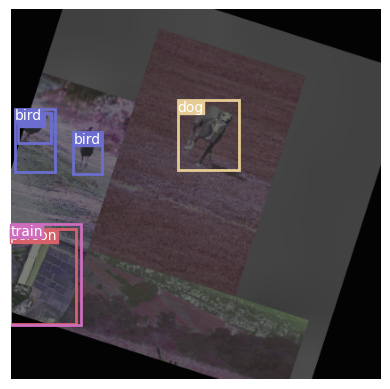

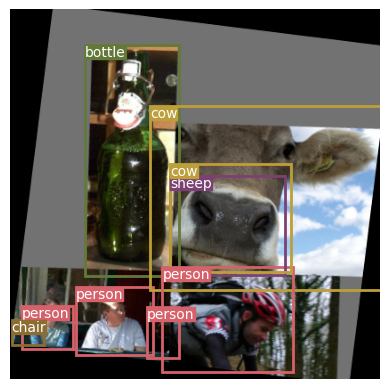

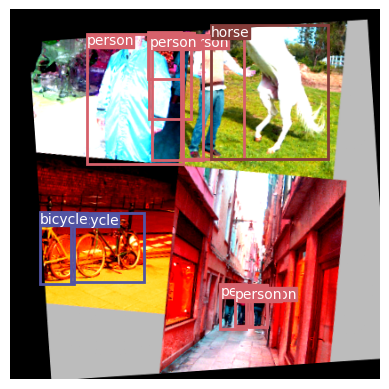

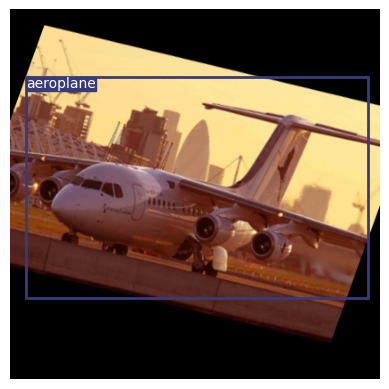

100%|██████████| 518/518 [01:26<00:00,  5.98it/s]


Train Metrics
Epoch: 39
Loss: 3.4298393726348877
Class Accuracy: 87.459534%
NoObject Accuracy: 98.114128%
Object Accuracy: 80.751427%


100%|██████████| 155/155 [00:27<00:00,  5.64it/s]


Test Metrics
Class Accuracy: 90.091438%
No Object Accuracy: 99.018707%
Object Accuracy: 73.546692%


100%|██████████| 155/155 [08:48<00:00,  3.41s/it]


MAP Value:  0.48722711205482483
Epoch 39: 100%|██████████| 518/518 [13:59<00:00,  1.62s/it, v_num=14, train_loss_step=2.740, train_loss_epoch=3.430]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 518/518 [14:01<00:00,  1.62s/it, v_num=14, train_loss_step=2.740, train_loss_epoch=3.430]


In [ ]:
CHECKPOINT_PATH = "checkpoints/"

# Initialize the model
model = Lit_Yolov3()

# Define the callbacks
callbacks = [ModelCheckpoint(dirpath=CHECKPOINT_PATH,verbose=True,),
                             AccuracyPlotCallback(every_n_epochs=40,train_every_n_epochs=40, test_every_n_epochs=40),
                             MAPCallback(every_n_epochs=40),
                             LearningRateMonitor(),
                             ModelSummary(max_depth=-1)]

# Instantiate the Trainer with callbacks
trainer = pl.Trainer(
    precision=16,
    max_epochs=40,
    callbacks=callbacks
)

trainer.fit(model)

In [ ]:
torch.save(model.state_dict(), 'results/Yolov3_Lavanya.pth')